# Option II - E-Commerce & Retail B2B Case Study

## Import Libaries

In [59]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Cleaning & Preparation

### Load Data

In [60]:
# import Received Payments Data
received = pd.read_csv('data/Received_Payments_Data.csv', encoding='UTF-8')
received.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [61]:
# import Open Invoice data
open = pd.read_csv('data/Open_Invoice_data.csv', encoding='UTF-8', encoding_errors='replace')
open.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [62]:
open[open['Transaction Number'] == 'RTD-�55,915.30-260721']

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
1084,04-APR-2022 01:07:01,Related Party,MANF Corp,48601.0,"RTD-�55,915.30-260721",26/07/2021,Immediate,26/07/2021,SAR,-151,PAYMENT,253,-40,7/27/2021 23:37


### Refine the Data

In [63]:
# check variable types
received.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [64]:
# Remove unecessary columns based on the Data Dictionary
received.drop(inplace=True, columns=[
    'RECEIPT_DOC_NO',  # reference number
    'Local Amount', # use USD amount instead
    'INVOICE_ALLOCATED', # reference number
    'CUSTOMER_NAME', # use CUSTOMER_NUMBER instead
])

In [65]:
# Remove records with Invoice Value equal to 0
received = received[received['USD Amount'] != 0]

In [66]:
# format date variables
date_cols = ['RECEIPT_DATE', 'INVOICE_CREATION_DATE', 'DUE_DATE']

for col in date_cols:
    received[col] = pd.to_datetime(received[col], format='%d-%b-%y')

In [67]:
# calculate TARGET variable
received['LATE_PAYMENT'] = received.apply(
    lambda x: 1 if (x['DUE_DATE'] - x['RECEIPT_DATE']).days < 0 else 0
    , axis= 1
)

In [68]:
# assign categorical variables
cate_cols = received.select_dtypes(include=['object']).columns

# check the values in the categorical variables
for i in cate_cols:
    print(received[i].value_counts(normalize=True))
    print('\n ------------------------------------------- \n')

RECEIPT_METHOD
WIRE             0.897318
AP/AR Netting    0.052224
CHEQUE           0.037409
CASH             0.008426
I/C WIRE         0.002273
PDC              0.002263
I/C Check        0.000065
I/C CASH         0.000022
Name: proportion, dtype: float64

 ------------------------------------------- 

CLASS
PMT    1.0
Name: proportion, dtype: float64

 ------------------------------------------- 

CURRENCY_CODE
AED    0.388176
SAR    0.385558
USD    0.208607
EUR    0.015494
GBP    0.001401
BHD    0.000636
KWD    0.000108
QAR    0.000022
Name: proportion, dtype: float64

 ------------------------------------------- 

PAYMENT_TERM
60 Days from Inv Date                                      0.212712
30 Days from Inv Date                                      0.151081
60 Days from EOM                                           0.134812
30 Days from EOM                                           0.121764
15 Days from EOM                                           0.081165
Immediate Payment     

In [69]:
# remaping some of the categorical values
received['PAYMENT_TERM'] = received['PAYMENT_TERM'].replace({'Immediate' : 'Immediate Payment'})

# binary transform
received['INVOICE_TYPE-GOODS'] = received['INVOICE_TYPE'].map({'Goods' : 1, 'Non Goods' : 0}).astype(int)
received.drop(columns= 'INVOICE_TYPE', inplace=True)

received['INVOICE_CLASS-INV'] = received['INVOICE_CLASS'].map({'INV' : 1, 'CM' : 0, 'DM' : 0}).astype(int)
received.drop(columns= 'INVOICE_CLASS', inplace=True)

# drop feature with 1 value
received.drop(columns= 'CLASS', inplace= True)

In [70]:
# define function to quickly map insignificant values to 'other'
def remove_insignificants(data, threshold = 0.05):
    proportions = data.value_counts(normalize=True)

    # Create a list of categories to keep (above the threshold)
    significant_categories = proportions[proportions > threshold].index.tolist()

    # Create a mapping where significant categories map to themselves and others map to 'Other'
    mapping = {category: (category if category in significant_categories else 'other') for category in data.unique()}

    # Apply the mapping to the DataFrame
    data.replace(mapping, inplace = True)

In [71]:
# reduce the insignificants in the dataset
remove_insignificants(received['RECEIPT_METHOD'], 0.03)
remove_insignificants(received['CURRENCY_CODE'], 0.02)
remove_insignificants(received['PAYMENT_TERM'], 0.01)
remove_insignificants(received['INVOICE_CURRENCY_CODE'], 0.02)

In [72]:
# re-assign categorical variables
cate_cols = received.select_dtypes(include=['object']).columns

## EDA

In [73]:
received.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92811 entries, 0 to 93936
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         92811 non-null  object        
 1   CUSTOMER_NUMBER        92811 non-null  int64         
 2   RECEIPT_DATE           92811 non-null  datetime64[ns]
 3   CURRENCY_CODE          92811 non-null  object        
 4   USD Amount             92811 non-null  float64       
 5   INVOICE_CREATION_DATE  92811 non-null  datetime64[ns]
 6   DUE_DATE               92811 non-null  datetime64[ns]
 7   PAYMENT_TERM           92811 non-null  object        
 8   INVOICE_CURRENCY_CODE  92811 non-null  object        
 9   LATE_PAYMENT           92811 non-null  int64         
 10  INVOICE_TYPE-GOODS     92811 non-null  int64         
 11  INVOICE_CLASS-INV      92811 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usag

### Check for outliers

In [74]:
num_cols = ['USD Amount']

<Axes: xlabel='USD Amount'>

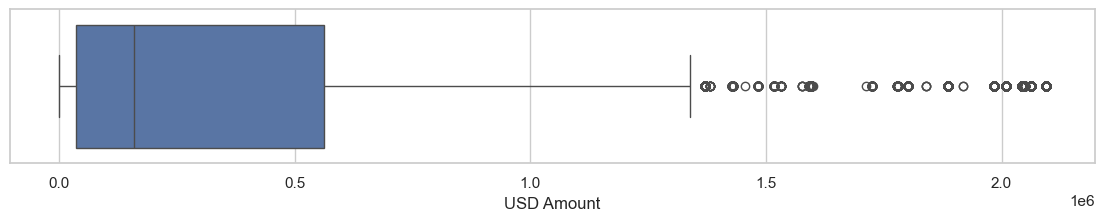

In [77]:
# plot the outliers using boxplot
plt.figure(figsize= (14, 2))
sns.boxplot(received['USD Amount'].astype(int), orient= 'h')

In [54]:
# use quartiles to remove outliers
received['USD Amount'].describe(percentiles=[.05, .1, .25, .5, .75, .9, .95, .97, .99]).astype(int)

count       92811
mean       537645
std        954807
min             1
5%           2572
10%          7829
25%         40452
50%        191287
75%        599613
90%       1257455
95%       2101629
97%       2771599
99%       5814128
max      10849828
Name: USD Amount, dtype: int64

> There are outliers in the 'USD Amount' that will have negative impact on the model's performance

In [ ]:
# remove the outliers base on the quantile 95%
received = received[received['USD Amount'] < received['USD Amount'].quantile(0.95)]

### Target Variable

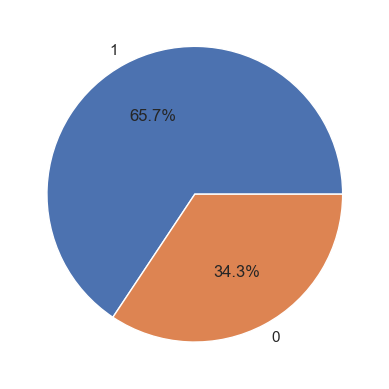

In [32]:
# plot taget variable
sns.set_theme(style="whitegrid")
plt.pie(received['LATE_PAYMENT'].value_counts(), labels= received['LATE_PAYMENT'].value_counts().index, autopct='%1.1f%%')
plt.show()

> About 2/3 payments are Late!

### Categoricals Variables

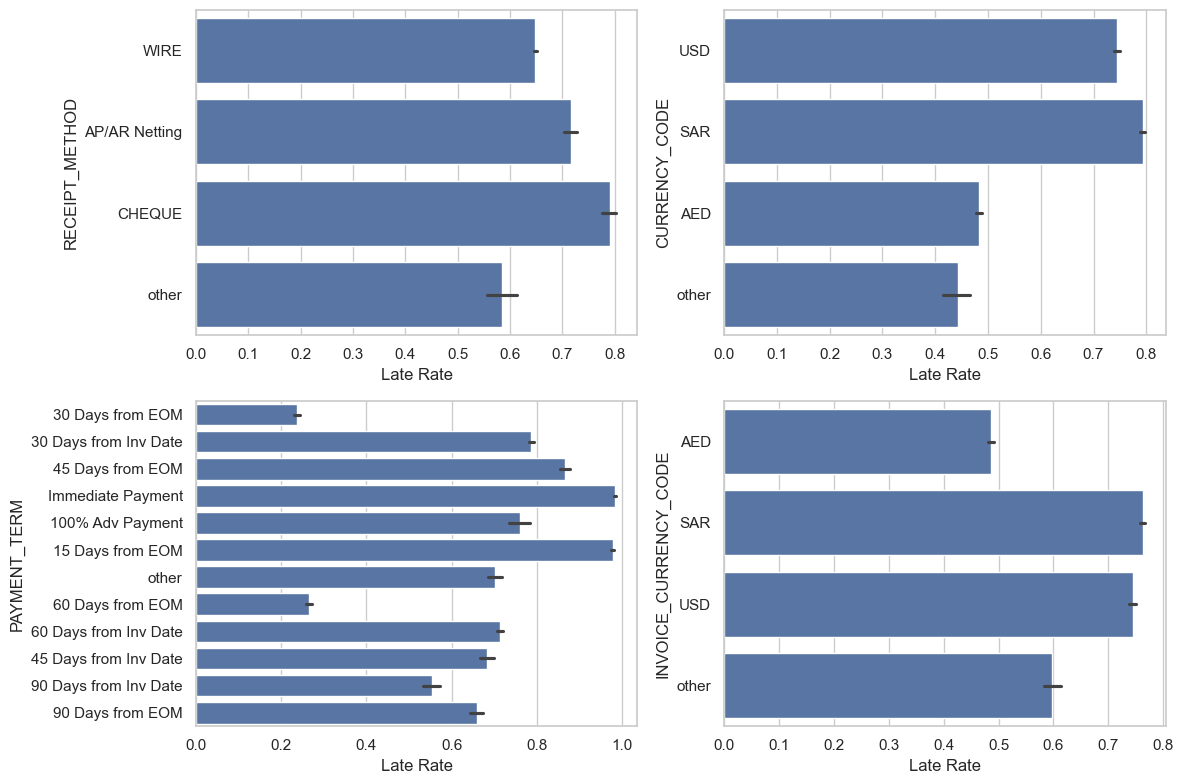

In [37]:
# Lets check the average Late rate of categorical variables
plt.figure(figsize=(12,8))
for i in range(len(cate_cols)):
    plt.subplot(2, 2, i+1)
    sns.barplot(data= received, y= cate_cols[i], x= 'LATE_PAYMENT')
    plt.xlabel('Late Rate')
    plt.ylabel(cate_cols[i])
plt.tight_layout()
plt.show();

## Features Engineering

## Users-based Unsupervised Clustering

## Test-Train split & scaling

## Model Building

## Model Evaluation

## Predictions on the Test set